In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import convolve
import time

In [2]:
def my_imfilter(s, filter, pad_type='zero'):
    """
    s: Input image (numpy array)
    filter: 2D filter (numpy array)
    pad_type: Type of padding - 'zero', 'replicate', or 'reflect'
    """
    # Get dimensions
    m, n = filter.shape
    h, w = s.shape
    
    # Define padding size
    pad_size = (m // 2, n // 2)
    
    # Apply padding based on pad_type
    if pad_type == 'zero':
        padded_image = np.pad(s, pad_size, mode='constant', constant_values=0)
    elif pad_type == 'replicate':
        padded_image = np.pad(s, pad_size, mode='edge')
    elif pad_type == 'reflect':
        padded_image = np.pad(s, pad_size, mode='reflect')
    else:
        raise ValueError("Invalid padding type")
    
    # Initialize the output image
    filtered_image = np.zeros_like(s)
    
    # Perform convolution
    for i in range(h):
        for j in range(w):
            region = padded_image[i:i+m, j:j+n]
            filtered_image[i, j] = np.sum(region * filter)
    
    return filtered_image

In [3]:
def load_and_preprocess_image(image_path):
    # Open the image and convert to grayscale
    image = Image.open(image_path).convert('L')
    
    # Resize to 256x256
    image = image.resize((256, 256))
    
    # Convert to numpy array
    image_array = np.array(image)
    
    return image_array

In [4]:
def apply_and_compare_filters(image_array, custom_filter, pad_type, library_filter_name):
    # Apply the custom filter
    filtered_image_custom = my_imfilter(image_array, custom_filter, pad_type=pad_type)
    
    # Apply the library filter using OpenCV or SciPy
    if library_filter_name == 'cv2_blur':
        filtered_image_library = cv2.filter2D(image_array, -1, custom_filter)
    elif library_filter_name == 'cv2_gaussian':
        filtered_image_library = cv2.GaussianBlur(image_array, (3, 3), 0)
    elif library_filter_name == 'cv2_laplacian':
        filtered_image_library = cv2.Laplacian(image_array, cv2.CV_64F)
    elif library_filter_name == 'scipy_convolve':
        filtered_image_library = convolve(image_array, custom_filter)
    else:
        raise ValueError("Unknown library filter name")

    # Display the original, custom filtered, and library filtered images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_array, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title(f'Custom Filter - {pad_type} Padding')
    plt.imshow(filtered_image_custom, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title(f'Library Filter ({library_filter_name})')
    plt.imshow(filtered_image_library, cmap='gray')

    plt.show()
    
    # Return both filtered images for further comparison
    return filtered_image_custom, filtered_image_library

In [5]:

# Function to calculate and display differences
def compare_filtered_images(filtered_custom, filtered_library):
    # Compute the absolute difference between the two filtered images
    difference = np.abs(filtered_custom - filtered_library)
    
    # Compute the Mean Squared Error (MSE)
    mse = np.mean(difference ** 2)
    
    # Compute the max difference
    max_diff = np.max(difference)
    
    #print(f'Mean Squared Error: {mse}')
    #print(f'Max Difference: {max_diff}')
    
    # Show the difference image
    plt.figure(figsize=(6, 6))
    plt.title('Difference Image')
    plt.imshow(difference, cmap='hot')
    plt.colorbar()
    plt.show()

    return mse, max_diff


In [6]:
# Example filters

smoothing_filter1 = np.array([[1, 1, 1],
                              [1, 1, 1],
                              [1, 1, 1]]) / 9

smoothing_filter = np.ones((5, 5)) / 25  # Smoothing filter (5x5 average)

sharpening_filter = np.array([[0, -1, 0],
                            [-1, 5, -1],
                            [0, -1, 0]])

log_filter = np.array([[0,  0, -1,  0,  0],
                       [0, -1, -2, -1,  0],
                       [-1, -2, 16, -2, -1],
                       [0, -1, -2, -1,  0],
                       [0,  0, -1,  0,  0]])

log_filter = log_filter / np.sum(np.abs(log_filter))  # Normalize LoG kernel


In [7]:
# Function to apply filters and compare results
def apply_and_compare_filters(image, custom_filter, library_filter, filter_name, library_filter_name, pad_type):
    # Measure the time for custom filter
    start_time_custom = time.time()  # Start time for custom filter
    filtered_custom = my_imfilter(image, custom_filter, pad_type=pad_type)  # Custom filter with pad_type
    end_time_custom = time.time()  # End time for custom filter

    # Measure the time for library filter
    start_time_library = time.time()  # Start time for OpenCV filter
    filtered_library = library_filter(image)
    end_time_library = time.time()  # End time for OpenCV filter

    # Normalize the output for comparison
    filtered_custom = cv2.normalize(filtered_custom, None, 0, 255, cv2.NORM_MINMAX)
    filtered_library = cv2.normalize(filtered_library, None, 0, 255, cv2.NORM_MINMAX)


    # Visual comparison with 3 images
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title(f'Custom Filter - {pad_type} Padding')
    plt.imshow(filtered_custom, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title(f'Library Filter ({library_filter_name})')
    plt.imshow(filtered_library, cmap='gray')

    plt.show()
    
    # Compare and calculate MSE and Max Difference
    mse, max_diff = compare_filtered_images(filtered_custom, filtered_library)
    print(f'{filter_name} MSE: {mse}, Max Difference: {max_diff}')
    print(f"{filter_name} Custom Filter Execution Time: {end_time_custom - start_time_custom:.6f} seconds")
    print(f"{library_filter_name} Library Filter Execution Time: {end_time_library - start_time_library:.6f} seconds\n\n")



image 1 with Smoothing  filter:


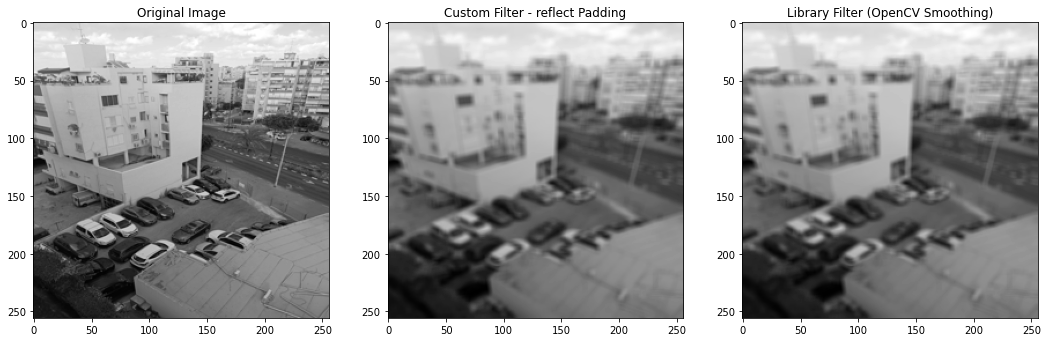

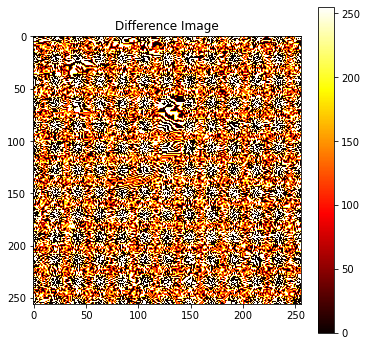

Smoothing MSE: 0.5181427001953125, Max Difference: 255
Smoothing Custom Filter Execution Time: 0.489690 seconds
OpenCV Smoothing Library Filter Execution Time: 0.000998 seconds


image 1 with Sharpening filter:


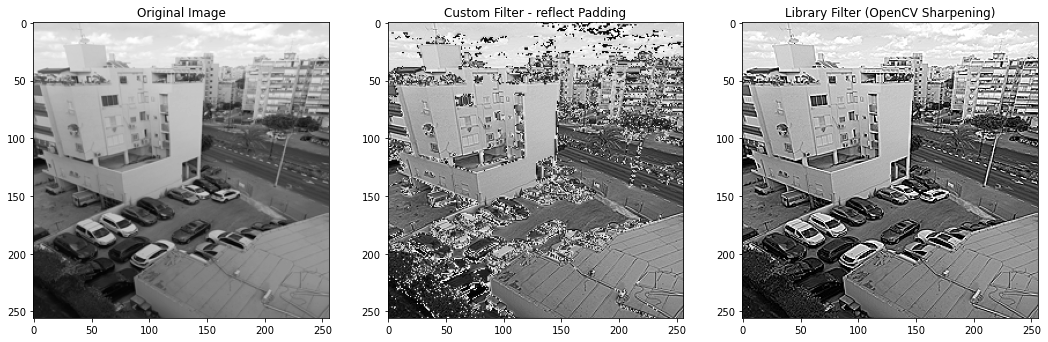

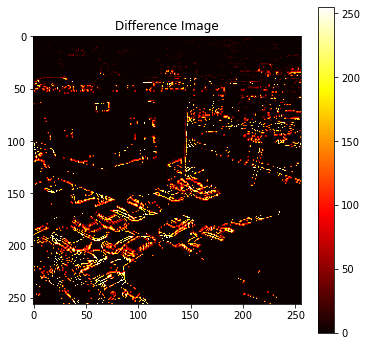

Sharpening MSE: 8.37469482421875, Max Difference: 255
Sharpening Custom Filter Execution Time: 0.452807 seconds
OpenCV Sharpening Library Filter Execution Time: 0.000000 seconds


image 1 with LoG (Laplace of Gaussian) filter:


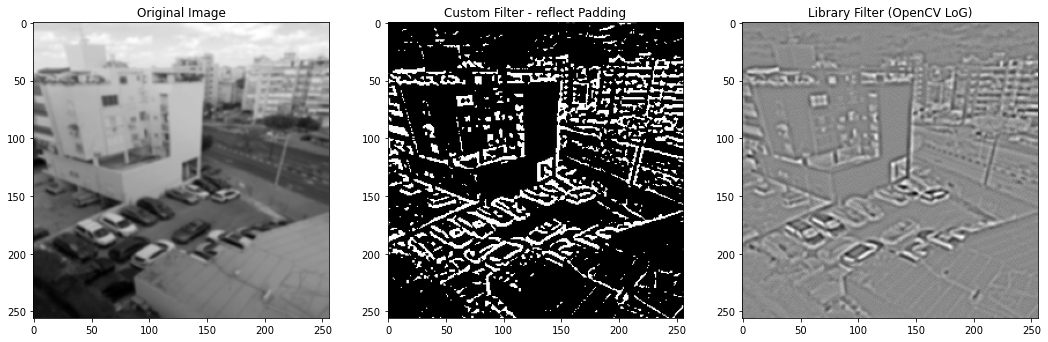

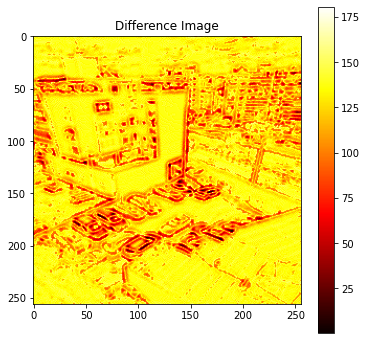

LoG MSE: 16103.82547211647, Max Difference: 180.625
LoG Custom Filter Execution Time: 0.462790 seconds
OpenCV LoG Library Filter Execution Time: 0.000969 seconds




In [8]:
# Load and preprocess the image
image_path = 'C:/Users/בר/Desktop/image3.jpg' 
image_array = load_and_preprocess_image(image_path)

print("image 1 with Smoothing  filter:")
# Apply smoothing filters and compare
apply_and_compare_filters(image_array, smoothing_filter, 
                          lambda img: cv2.blur(img, (5, 5)), 
                          "Smoothing", "OpenCV Smoothing", pad_type='reflect')

print("image 1 with Sharpening filter:")
# Apply sharpening filters and compare
apply_and_compare_filters(image_array, sharpening_filter, 
                          lambda img: cv2.filter2D(img, -1, sharpening_filter), 
                          "Sharpening", "OpenCV Sharpening", pad_type='reflect')

# Apply Gaussian blur to smooth image for consistency
blurred_image_custom = cv2.GaussianBlur(image_array, (5, 5), 0)

print("image 1 with LoG (Laplace of Gaussian) filter:")
# Apply LoG filters and compare
apply_and_compare_filters(blurred_image_custom, log_filter, 
                          lambda img: cv2.Laplacian(cv2.GaussianBlur(img, (5, 5), 0), cv2.CV_64F), 
                          "LoG", "OpenCV LoG", pad_type='reflect')

image 2 with Smoothing  filter:


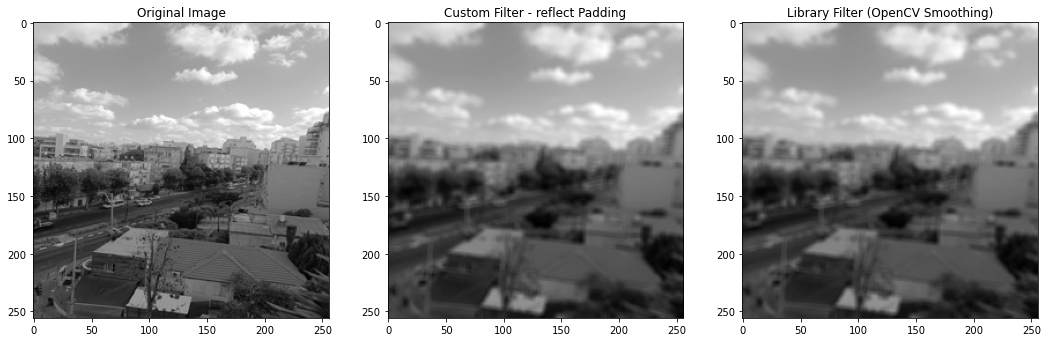

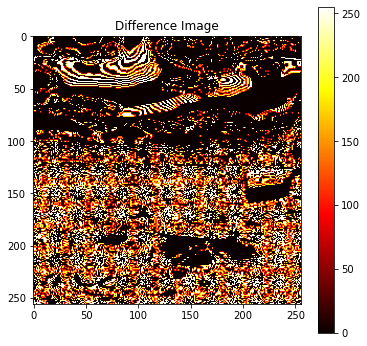

Smoothing MSE: 0.5171356201171875, Max Difference: 255
Smoothing Custom Filter Execution Time: 0.455780 seconds
OpenCV Smoothing Library Filter Execution Time: 0.000000 seconds


image 2 with Sharpening filter:


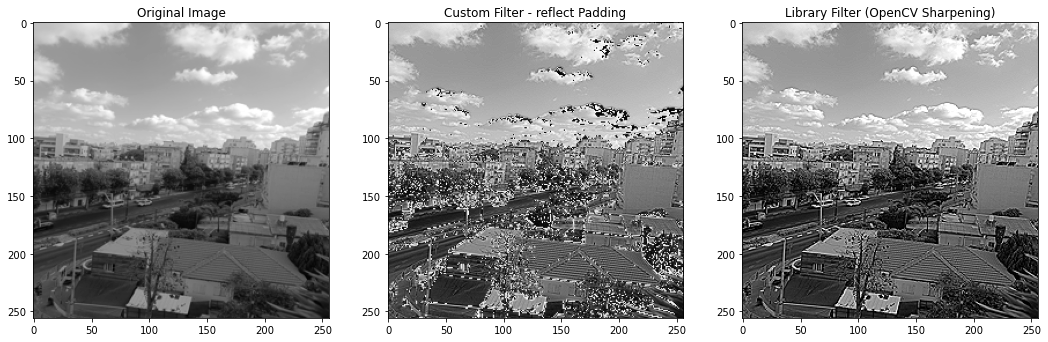

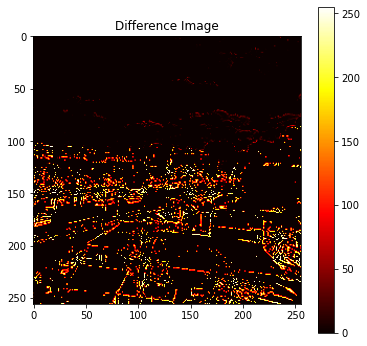

Sharpening MSE: 6.1151123046875, Max Difference: 255
Sharpening Custom Filter Execution Time: 0.440820 seconds
OpenCV Sharpening Library Filter Execution Time: 0.000000 seconds


image 2 with LoG (Laplace of Gaussian) filter:


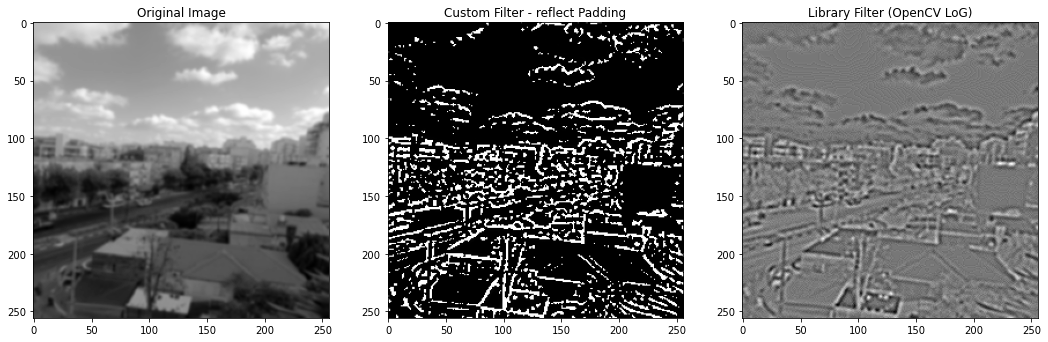

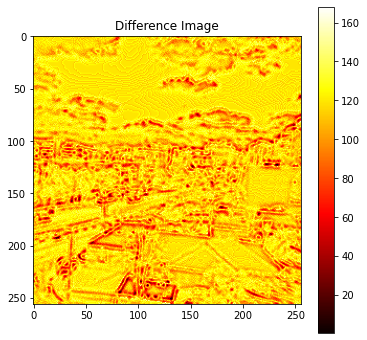

LoG MSE: 12990.83004778702, Max Difference: 168.19148936170214
LoG Custom Filter Execution Time: 0.454811 seconds
OpenCV LoG Library Filter Execution Time: 0.000989 seconds




In [9]:
# Load and preprocess the image
image_path = 'C:/Users/בר/Desktop/image2.jpg' 
image_array = load_and_preprocess_image(image_path)

print("image 2 with Smoothing  filter:")
# Apply smoothing filters and compare
apply_and_compare_filters(image_array, smoothing_filter, 
                          lambda img: cv2.blur(img, (5, 5)), 
                          "Smoothing", "OpenCV Smoothing", pad_type='reflect')

print("image 2 with Sharpening filter:")
# Apply sharpening filters and compare
apply_and_compare_filters(image_array, sharpening_filter, 
                          lambda img: cv2.filter2D(img, -1, sharpening_filter), 
                          "Sharpening", "OpenCV Sharpening", pad_type='reflect')

# Apply Gaussian blur to smooth image for consistency
blurred_image_custom = cv2.GaussianBlur(image_array, (5, 5), 0)

print("image 2 with LoG (Laplace of Gaussian) filter:")
# Apply LoG filters and compare
apply_and_compare_filters(blurred_image_custom, log_filter, 
                          lambda img: cv2.Laplacian(cv2.GaussianBlur(img, (5, 5), 0), cv2.CV_64F), 
                          "LoG", "OpenCV LoG", pad_type='reflect')